# Analysis of light curve periods

In this notebook I will describe the process for calculating the periods of `LINEAR` light curves and `ZTF` light curves using the *Lomb-Scargle periodogram*. Afterwards, we will save all of the periods and the number of observation points in a `DataFrame` which I will then analyze using descriptive statistics. 

In [1]:
# importing all of the necessary libraries
import numpy as np
import seaborn as sns
import pandas as pd
import scipy as sc
import random
import pickle

from matplotlib import pyplot as plt
from scipy.stats import norm

from astroML.utils.decorators import pickle_results
from astroML.time_series import search_frequencies, lomb_scargle, MultiTermFit
#from gatspy import periodic
from astropy.timeseries import LombScargle
from astroML.datasets import fetch_LINEAR_sample

from ztfquery import lightcurve
from matplotlib import ticker
import dask.dataframe as dd 
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
import threading
import os
import random

np.random.seed(42)
%matplotlib inline  

In [2]:
sns.set_theme() # setting the theme for plotting

In [3]:
import sys
sys.path.insert(0,'../src/')
sys.path
from ZTF_data import data_ztf
from descriptive_stats import*
from plotting import*
from config import*
from periods import calculating_period

Loading the data!
Loading the data!
Loading the data!


## What is the Lomb-Scargle periodogram?

The Lomb-Scargle method of computing the period of a variable star using light curves involves fitting multi-level sinusoidal waves to our light curve data over various trial periods, and the period with the largest strength or the best fit is the real period.

This is the formula for the Lomb-Scargle periodogram:

$$P(ω)= \frac{1}{2σ^2}​*(\frac{[∑y_k cosω(t_k−τ)]^2}{∑cos^2 ω(t_k−τ)} + \frac{[∑y_k sin ω(t_k−τ)]^2}{∑ sin^2 ω(t_k−τ)})$$

- $ω$ is the frequency we are testing to see if it matches with our light curve.
- $σ^2$ is the variance of the data. We are dividing by it to normalize the data to work across all distributions.
- $∑y_k cosω(t_k−τ)$ and $∑y_k sin ω(t_k−τ)$: checking how well the fitted cosine and sine waves align with the data. $t_k$ is the particular time point, and $τ$ is the time delay, for efficiency.
- $∑cos^2 ω(t_k−τ)$ and $∑ sin^2 ω(t_k−τ)$: normalization of the fitting, in order to eliminate bias towards very strong and/or weak wave components. 

## Why do I use the Lomb-Scargle periodogram?

We use the Lomb-Scargle periodogram because it is the most popular tool used for determining the period of periodic variable stars. It combines multiple methods of analysis, with it's core being in Fourier analysis, and the fact that it operates with non-uniformly spaced data, such is the nature of light curves.

# Calculating the periods

# `LINEAR` dataset

In [4]:
data = fetch_LINEAR_sample(data_home='../inputs') # fetching the data from astroML data library

### Example: light curve 10032668

Here, we are going to calculate the period and phase the light curve of star 10032668. 

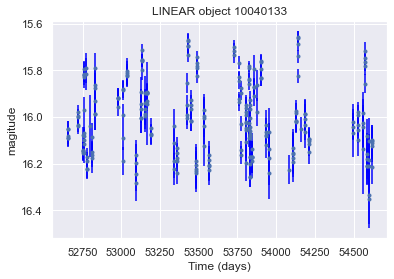

In [31]:
# plotting the light curve

t, mag, mager = data.get_light_curve(data.ids[10]).T
fig, ax = plt.subplots()
ax.errorbar(t, mag, mager, fmt='.b', ecolor='blue')
ax.set(xlabel='Time (days)', ylabel='magitude',
       title='LINEAR object {0}'.format(data.ids[10]))
ax.invert_yaxis()

After looking at the light curve in total, it is time to calculate the period. I use, as mentioned before, the Lomb-Scargle method, and the function is from the `Astropy` library. 

In [32]:
ls = LombScargle(t, mag, mager) # setting up the Lomb-Scargle object

# calculating the frequency and the power of each frequency for that light curve
frequency, power = ls.autopower(nyquist_factor=350) # here the nyquist factor is pretty high so we don't miss out on a frequency which might be important

# calculating the period
period = 1. / frequency # formula for the period
best_period = period[np.argmax(power)] # choosing the period with the most power
best_frequency = frequency[np.argmax(power)] # choosing the frequency with the highest power

phase = (t / best_period) % 1 # calculating the phase

In [33]:
best_period

0.6105450399303926

We see that for this light curve, the period is around 0.61 days. This is quite a short period, most likely a RR Lyrae star.

We can plot the Lomb-Scargle periodogram so we can see the power of each frequency.

[(0.2, 1.4), (0.0, 0.8), Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Power')]

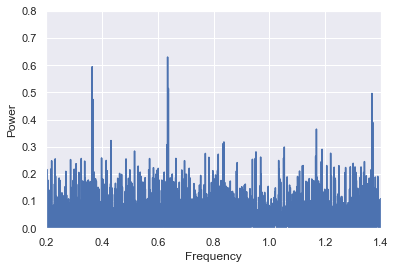

In [34]:
fig, ax = plt.subplots()
ax.plot(frequency, power)
ax.set(xlim=(0.2, 1.4), ylim=(0, 0.8),
       xlabel='Frequency',
       ylabel='Power')

We can clearly see that around 0.6 is the most power. Let's plot the phased light curve!

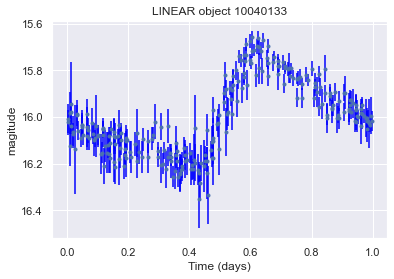

In [35]:
fig, ax = plt.subplots()
ax.errorbar(phase, mag, mager, fmt='.b', ecolor='blue')
ax.set(xlabel='Time (days)', ylabel='magitude',
       title='LINEAR object {0}'.format(data.ids[10]))
ax.invert_yaxis()

This looks much better than the previous light curve plot! We can actually see the structure. 

# Calculating LINEAR periods

In [4]:
LINEAR_data = calculating_period('LINEAR', 1, 'LINEAR',testing=False)

Loading LINEAR data!


In [5]:
LINEAR_data

,ID,Frequency,Period,N
0,10003298.0,8.067333,0.123957,196.0
1,10004892.0,1.486845,0.672565,269.0
2,10013411.0,1.800789,0.555312,170.0
3,10021274.0,1.733287,0.576939,214.0
4,10022663.0,1.623512,0.615949,246.0
...,...,...,...,...
7005,9983476.0,2.252320,0.443987,286.0
7006,9983939.0,2.231729,0.448083,466.0
7007,9984569.0,2.867441,0.348743,478.0
7008,9987252.0,0.800516,1.249194,404.0


# `ZTF` dataset

In [6]:
ZTF = np.load('../inputs/ZTF_curves.npy', allow_pickle=True) # loading the data

## Calculating ZTF periods

In [7]:
ZTF_data = calculating_period('ZTF', 1, 'ZTF', testing=False)

Loading ZTF data!


In [38]:
ZTF_data, LINEAR_data

(          ID  Frequency    Period       N
 0        0.0   8.067305  0.078646  2197.0
 1        1.0   2.489658  0.655841    39.0
 2        2.0   2.800860  0.053510  1404.0
 3        3.0   1.733282  0.645009  1995.0
 4        4.0   1.623467  0.578431  1533.0
 ...      ...        ...       ...     ...
 6827  7004.0   3.201690  0.770133   546.0
 6828  7006.0   2.231881  0.694322   553.0
 6829  7007.0   2.867459  0.557196   549.0
 6830  7008.0   1.803291  0.561482   547.0
 6831  7009.0   1.518862  0.503702   610.0
 
 [6832 rows x 4 columns],
               ID  Frequency    Period      N
 0     10003298.0   8.067333  0.123957  196.0
 1     10004892.0   1.486845  0.672565  269.0
 2     10013411.0   1.800789  0.555312  170.0
 3     10021274.0   1.733287  0.576939  214.0
 4     10022663.0   1.623512  0.615949  246.0
 ...          ...        ...       ...    ...
 7005   9983476.0   2.252320  0.443987  286.0
 7006   9983939.0   2.231729  0.448083  466.0
 7007   9984569.0   2.867441  0.348743  47

### Discussion of the results

Our pool of light curves contain many light curves with only one "dip", however there is a large proportion of stars which are **eclipsing binaries**. These stars produce 2 dips, and using the Lomb-Scargle algorithm has to be adjusted. In the algorithm, we can use multi-term period fitting. In the tables beforehand, I used a standard sine wave, which works well for 1 dip stars, but poorly on eclipsing binaries. In the next section I will be using multi-term fitting to recalculate the periods, and hopefully correct the periods for eclipsing binaries. 

## Calculating the periods using multi-term sine waves

In [45]:
from gatspy.periodic import LombScargleFast
star_id = 10040133
t, mag, dmag = data.get_light_curve(star_id).T
model = LombScargle().fit(t, mag, dmag)
periods, power = model.periodogram_auto(nyquist_factor=350,Nterms=4)

TypeError: LombScargle.__init__() missing 2 required positional arguments: 't' and 'y'

In [ ]:
LINEAR_data_multi = calculating_period('LINEAR', 4,'LINEAR_multi')

In [ ]:
ZTF_data_multi = calculating_period('ZTF', 6,'ZTF_multi', testing=False)

# Analysis of the periods of the light curves

#### LINEAR

In [9]:
LINEAR_p = lc_descriptive_dataframe(LINEAR_data, 'Period')
LINEAR_p

,mean,median,std,amin,amax,skew,kurtosis,Amplitude
index,,,,,,,,
Period,194.683925,0.403606,1762.907772,0.044615,22199.9071,10.634837,114.066781,22199.862485


In [10]:
LINEAR_f = lc_descriptive_dataframe(LINEAR_data, 'Frequency')
LINEAR_f

,mean,median,std,amin,amax,skew,kurtosis,Amplitude
index,,,,,,,,
Frequency,3.610964,2.477667,2.862791,0.000045,22.414095,1.574735,4.068978,22.41405


#### ZTF

In [11]:
ZTF_p = lc_descriptive_dataframe(ZTF_data, 'Period')
ZTF_p

,mean,median,std,amin,amax,skew,kurtosis,Amplitude
index,,,,,,,,
Period,0.696257,0.451581,14.926585,0.011528,1069.01503,62.044213,4135.503099,1069.003502


In [12]:
ZTF_f = lc_descriptive_dataframe(ZTF_data, 'Frequency')
ZTF_f

,mean,median,std,amin,amax,skew,kurtosis,Amplitude
index,,,,,,,,
Frequency,4.27416,2.817324,6.076244,0.000053,262.345395,16.378919,535.996139,262.345341


#### Multi-term LINEAR

In [ ]:
LINEAR_f_multi = lc_descriptive_dataframe(LINEAR_data_multi, 'Frequency')
LINEAR_f_multi

In [ ]:
LINEAR_p_multi = lc_descriptive_dataframe(LINEAR_data_multi, 'Frequency')
LINEAR_p_multi

#### Multi-term ZTF

In [ ]:
ZTF_f_multi = lc_descriptive_dataframe(ZTF_data_multi, 'Frequency')
ZTF_f_multi

In [ ]:
ZTF_p_multi = lc_descriptive_dataframe(ZTF_data_multi, 'Frequency')
ZTF_p_multi

## Analysis of graphs

## Plotting examples of phased light curves from both `LINEAR` and `ZTF`

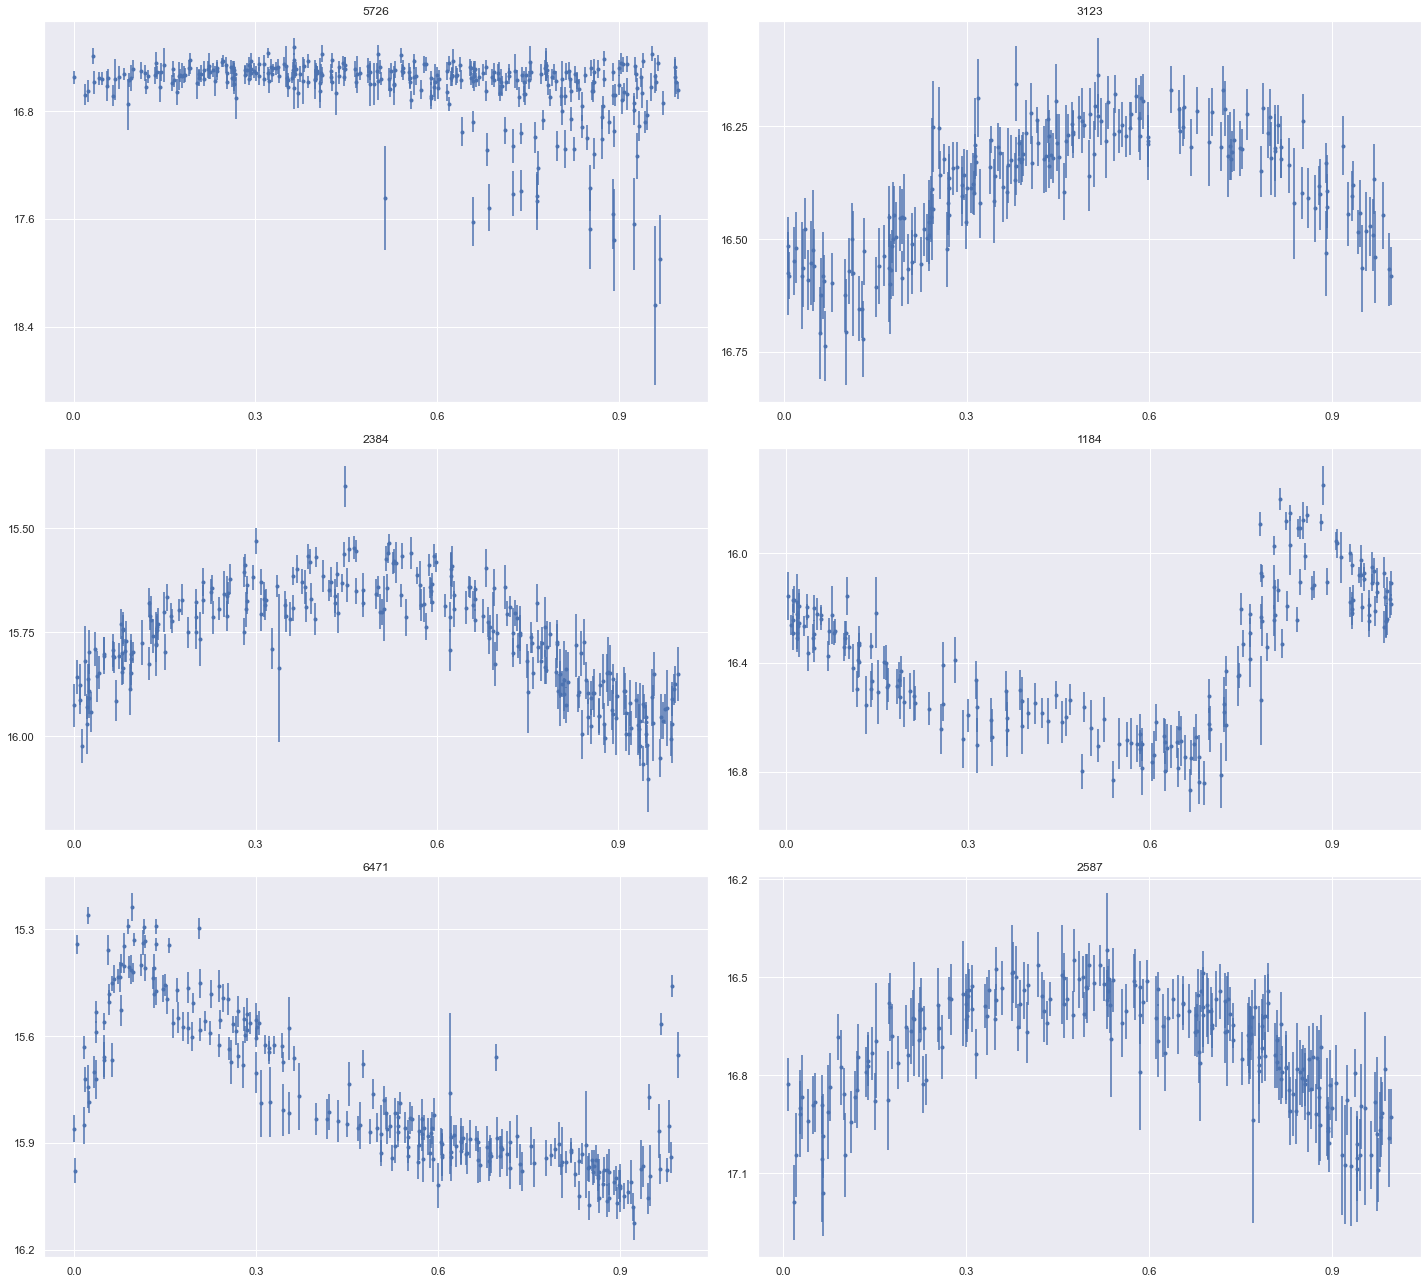

In [9]:
plotting_lc_phased(LINEAR_data, 'LINEAR', 6, 3, 2)

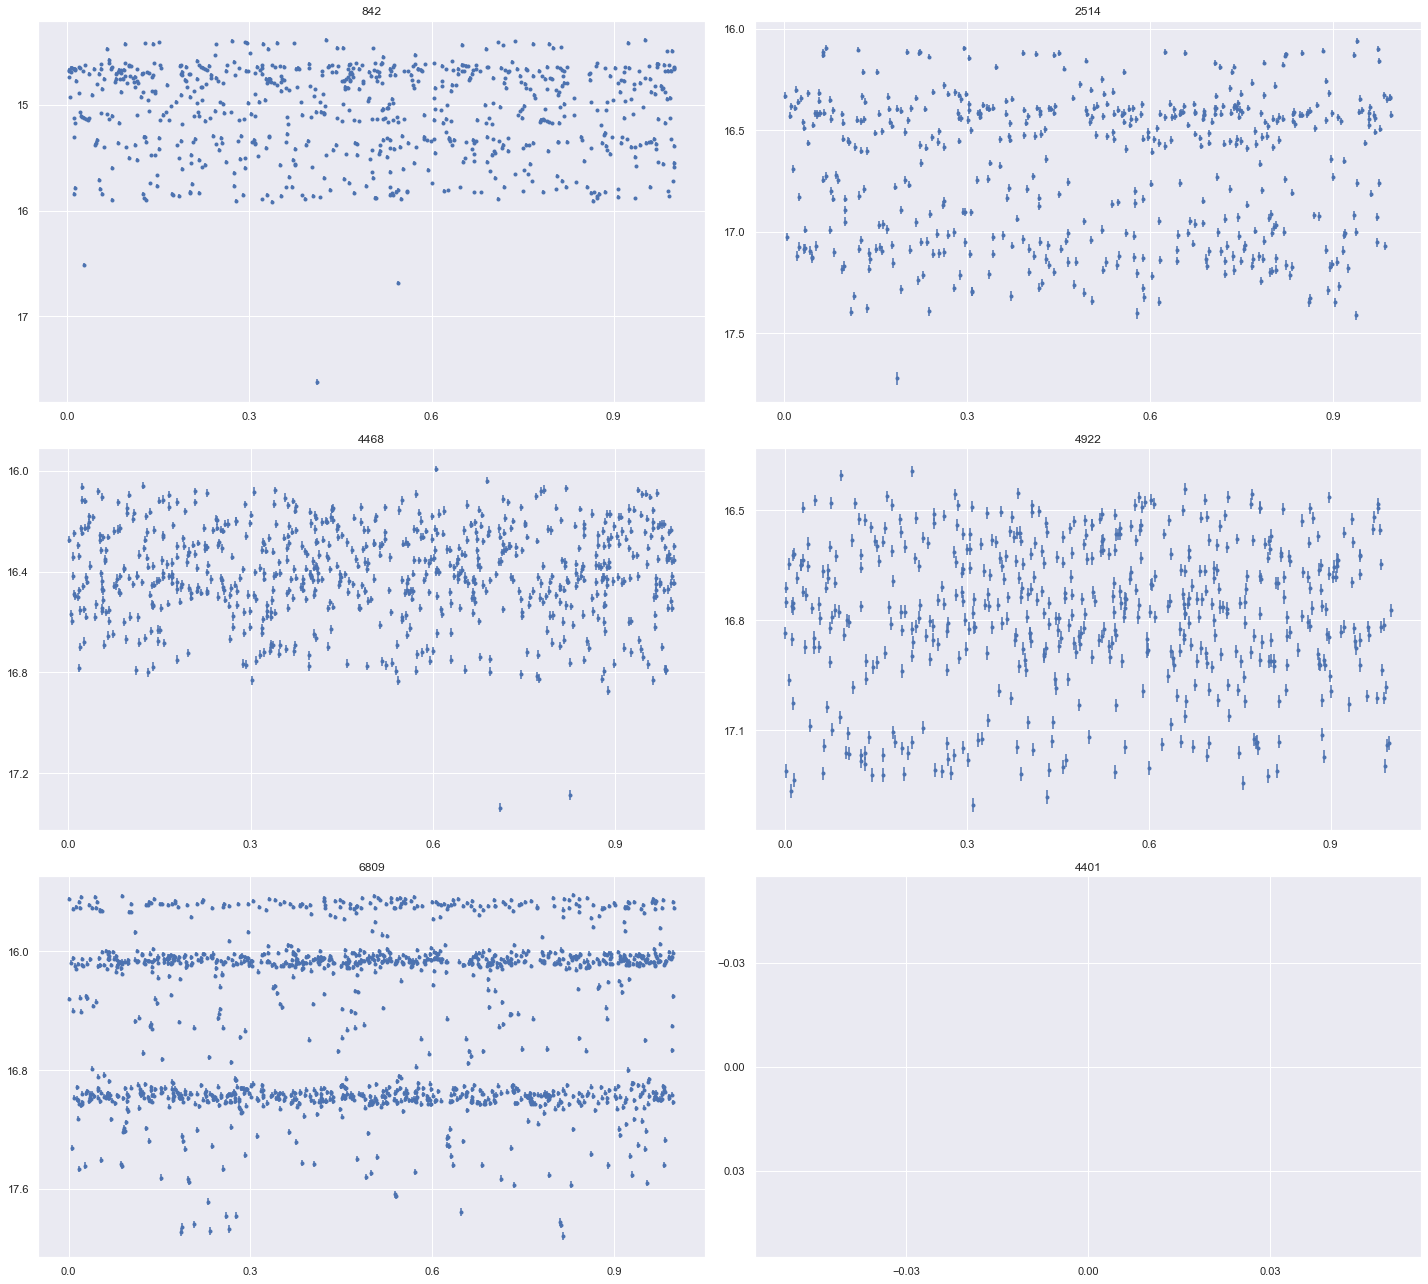

In [37]:
plotting_lc_phased(ZTF_data, 'ZTF', 6, 3, 2)

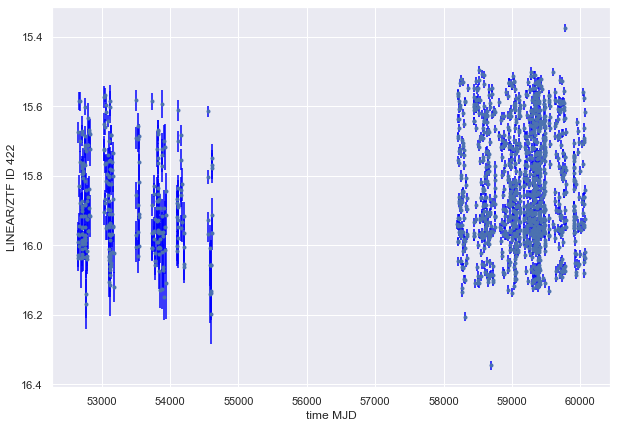

In [71]:
ID = np.where(data.ids==11375941)[0][0]

#linear
tL, mL, dmL = data[11375941].T

#ztf
lc = ZTF[422][1]
tZ, mZ, dmZ = lc['mjd'], lc['mag'], lc['magerr']
tZ, mZ, dmZ = tZ.to_numpy(), mZ.to_numpy(), dmZ.to_numpy()

#plotting both
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.errorbar(tL, mL, dmL, fmt='.b', ecolor='blue')
ax.errorbar(tZ, mZ, dmZ, fmt='.b', ecolor='blue')
ax.set_xlabel('time MJD')
ax.set_ylabel('LINEAR/ZTF ID 422')
ax.invert_yaxis()

In [72]:
# LINEAR
#----------
lsL = LombScargle(tL, mL, dmL, nterms=5) # setting up the Lomb-Scargle object
frequencyL, powerL = lsL.autopower(nyquist_factor=350) # here the nyquist factor is pretty high so we don't miss out on a frequency which might be important
periodL = 1. / frequencyL # formula for the period
best_periodL = periodL[np.argmax(powerL)] # choosing the period with the most power
phaseL = (tL / best_periodL) % 1 # calculating the phase

In [73]:
#ZTF
lsZ = LombScargle(tZ, mZ, dmZ, nterms=5) # setting up the Zomb-ScargZe object
frequencyZ, powerZ = lsZ.autopower(nyquist_factor=350) # here the nyquist factor is pretty high so we don't miss out on a frequency which might be important
periodZ = 1. / frequencyZ # formuZa for the period
best_periodZ = periodZ[np.argmax(powerZ)] # choosing the period with the most power
phaseZ = (tZ / best_periodZ) % 1 # caZcuZating the phase

In [74]:
best_periodL, best_periodZ

(0.10750614372530654, 0.10750620258359785)

[(0.2, 1.4),
 (0.0, 0.8),
 Text(0.5, 0, 'Frequency ZTF'),
 Text(0, 0.5, 'Power ZTF')]

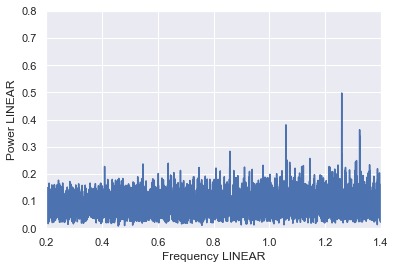

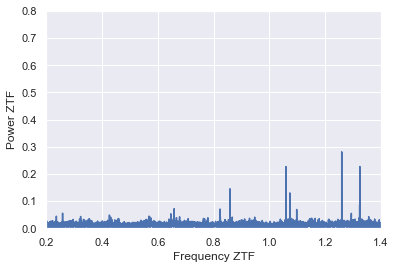

In [78]:
fig, ax = plt.subplots()
ax.plot(frequencyL, powerL)
ax.set(xlim=(0.2, 1.4), ylim=(0, 0.8),
       xlabel='Frequency LINEAR',
       ylabel='Power LINEAR')

fig, ax = plt.subplots()
ax.plot(frequencyZ, powerZ)
ax.set(xlim=(0.2, 1.4), ylim=(0, 0.8),
       xlabel='Frequency ZTF',
       ylabel='Power ZTF')

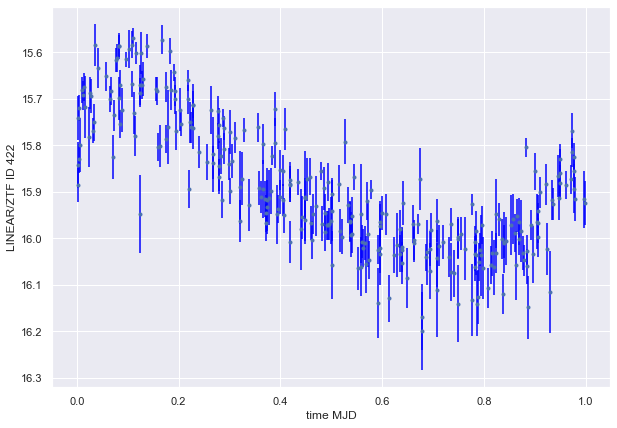

In [80]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.errorbar(phaseL, mL, dmL, fmt='.b', ecolor='blue')
ax.set_xlabel('time MJD')
ax.set_ylabel('LINEAR/ZTF ID 422')
ax.invert_yaxis()

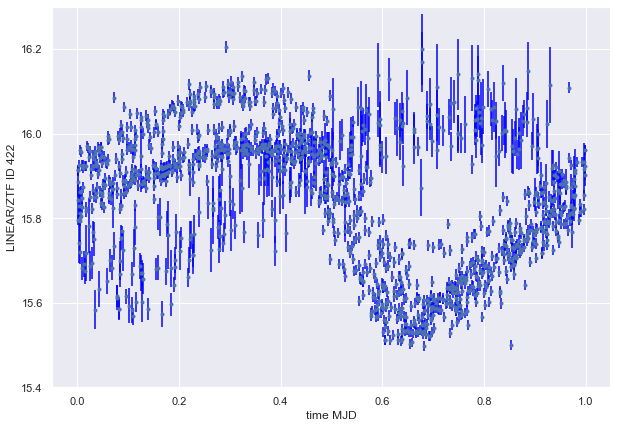

In [82]:

fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.errorbar(phaseL, mL, dmL, fmt='.b', ecolor='blue')
ax.errorbar(phaseZ, mZ, dmZ, fmt='.b', ecolor='blue')
ax.set_ylim(16.3, 15.4)
ax.set_xlabel('time MJD')
ax.set_ylabel('LINEAR/ZTF ID 422')
ax.invert_yaxis()

In [84]:
mtfL = MultiTermFit(best_periodL, 5)
mtfL.fit(tL, mL, dmL)
phaseL, mfitL, phasedtL = mtfL.predict(1000, return_phased_times=True)

mtfZ = MultiTermFit(best_periodZ, 5)
mtfZ.fit(tZ, mZ, dmZ)
phaseZ, mfitZ, phasedtZ = mtfZ.predict(1000, return_phased_times=True)

(16.3, 15.4)

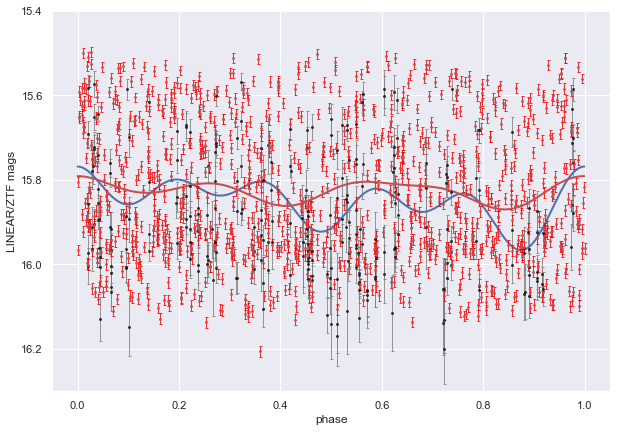

In [85]:
fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.set_xlabel('phase')
ax.set_ylabel('LINEAR/ZTF mags')

# LINEAR data
ax.errorbar(phasedtL, mL, dmL, fmt='.k', ecolor='gray', lw=1, ms=4, capsize=1.5, alpha=0.8)
ax.plot(phaseL, mfitL, 'b', markeredgecolor='b', lw=2, fillstyle='top', linestyle='solid')
# ZTF data
ax.errorbar(phasedtZ, mZ, dmZ, fmt='.r', ecolor='red', lw=1, ms=4, capsize=1.5, alpha=0.8)
ax.plot(phaseZ, mfitZ, 'r', markeredgecolor='r', lw=2, fillstyle='top', linestyle='solid')


ax.set_ylim(16.3, 15.4)